<a href="https://colab.research.google.com/github/chitra-psg/bike_sharing/blob/main/bike_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BoomBikes Demand Regression

### BoomBikes  wanted to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

*   Which variables are significant in predicting the demand for shared bikes.
*   How well those variables describe the bike demands

In [248]:
# Import the required modules
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configurations
import warnings
warnings.filterwarnings('ignore')

In [249]:
# Function to calcualte VIF 
def GetVIF(X_train):
  vif = pd.DataFrame()
  X = X_train
  vif['Features'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  return vif

# Function to create linear regession model and fit it.
def GetLinearRegression(X_train, y_train):
    # Add a constant
    X_train_lm = sm.add_constant(X_train)
    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    return lr


In [250]:
# A function has been created to map the actual numbers to categorical levels.

# Assigning string values to different months instead of numeric values which may misindicate some order to it.
def MapMonths(x):
    return x.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'})

def MapSeasons(x):
    return x.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

def MapWeather(x):
    return x.map({1: 'Clear', 2: 'Cloudy', 3: 'LightRain', 4: 'HeavyRain'})

def MapBoolean(x):
    return x.map({0: 'No', 1: 'Yes'})

In [251]:
# Load the source data from GitHub into dataframe for analysis
# Load all column data in and then determine data type : low_memory=False
df_bike = pd.read_csv("https://github.com/chitra-psg/bike_sharing/blob/main/day.csv?raw=True", low_memory=False)
df_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.1108,18.1812,80.5833,10.7499,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.9026,17.6869,69.6087,16.6521,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.0509,9.4703,43.7273,16.6367,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.2000,10.6061,59.0435,10.7398,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.3052,11.4635,43.6957,12.5223,82,1518,1600


In [252]:
df_bike.info()
# Summary :
# Most of the columns are numeric type except date and date will have to be converted to Date type.
# There doesnt seem to be any nulls in any row/column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [253]:
df_bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000,730.0000
mean,365.5000,2.4986,0.5000,6.5260,0.0288,2.9973,0.6836,1.3945,20.3193,23.7263,62.7652,12.7636,849.2493,3658.7575,4508.0068
std,210.8771,1.1102,0.5003,3.4502,0.1673,2.0062,0.4654,0.5448,7.5067,8.1503,14.2376,5.1958,686.4799,1559.7587,1936.0116
min,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,2.4243,3.9535,0.0000,1.5002,2.0000,20.0000,22.0000
25%,183.2500,2.0000,0.0000,4.0000,0.0000,1.0000,0.0000,1.0000,13.8119,16.8897,52.0000,9.0417,316.2500,2502.2500,3169.7500
50%,365.5000,3.0000,0.5000,7.0000,0.0000,3.0000,1.0000,1.0000,20.4658,24.3682,62.6250,12.1253,717.0000,3664.5000,4548.5000
75%,547.7500,3.0000,1.0000,10.0000,0.0000,5.0000,1.0000,2.0000,26.8806,30.4458,72.9896,15.6256,1096.5000,4783.2500,5966.0000
max,730.0000,4.0000,1.0000,12.0000,1.0000,6.0000,1.0000,3.0000,35.3283,42.0448,97.2500,34.0000,3410.0000,6946.0000,8714.0000


In [254]:

# instant is just row number
# dteday is a date field which is also available in yr and mnt column
# Focus is to look at overall prediction rather than the type of bike share so can drop casual &	registered

# Choose other columns to be dropped -
# temp and atemp are highly correlated. we can drop one of these
pd.options.display.float_format = '{:.4f}'.format
df_bike.corr()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.0000,0.4136,0.8660,0.4983,0.0163,-0.0000,-0.0046,-0.0219,0.1507,0.1528,0.0161,-0.1127,0.2756,0.6605,0.6299
season,0.4136,1.0000,-0.0000,0.8310,-0.0109,-0.0031,0.0138,0.0213,0.3334,0.3420,0.2082,-0.2296,0.2087,0.4103,0.4046
yr,0.8660,-0.0000,1.0000,-0.0000,0.0082,-0.0055,-0.0029,-0.0503,0.0488,0.0472,-0.1125,-0.0116,0.2505,0.5969,0.5697
mnth,0.4983,0.8310,-0.0000,1.0000,0.0189,0.0095,-0.0047,0.0456,0.2191,0.2264,0.2249,-0.2080,0.1212,0.2920,0.2782
holiday,0.0163,-0.0109,0.0082,0.0189,1.0000,-0.1020,-0.2529,-0.0344,-0.0288,-0.0327,-0.0157,0.0063,0.0541,-0.1091,-0.0688
weekday,-0.0000,-0.0031,-0.0055,0.0095,-0.1020,1.0000,0.0358,0.0311,-0.0002,-0.0075,-0.0523,0.0143,0.0600,0.0574,0.0675
workingday,-0.0046,0.0138,-0.0029,-0.0047,-0.2529,0.0358,1.0000,0.0602,0.0535,0.0529,0.0232,-0.0187,-0.5176,0.3054,0.0625
weathersit,-0.0219,0.0213,-0.0503,0.0456,-0.0344,0.0311,0.0602,1.0000,-0.1195,-0.1206,0.5903,0.0398,-0.2460,-0.2590,-0.2959
temp,0.1507,0.3334,0.0488,0.2191,-0.0288,-0.0002,0.0535,-0.1195,1.0000,0.9917,0.1286,-0.1582,0.5427,0.5394,0.6270
atemp,0.1528,0.3420,0.0472,0.2264,-0.0327,-0.0075,0.0529,-0.1206,0.9917,1.0000,0.1415,-0.1839,0.5434,0.5437,0.6307


In [255]:
ls_columns_to_be_dropped = ['instant', 'dteday', 'casual', 'registered','atemp']

df_bike.drop(ls_columns_to_be_dropped, axis=1, inplace=True)
df_bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.1108,80.5833,10.7499,985
1,1,0,1,0,0,0,2,14.9026,69.6087,16.6521,801
2,1,0,1,0,1,1,1,8.0509,43.7273,16.6367,1349
3,1,0,1,0,2,1,1,8.2000,59.0435,10.7398,1562
4,1,0,1,0,3,1,1,9.3052,43.6957,12.5223,1600


In [256]:

# Applying the function to the two columns
df_bike[['mnth']] = df_bike[['mnth']].apply(MapMonths)
df_bike[['season']] = df_bike[['season']].apply(MapSeasons)
df_bike[['weathersit']] = df_bike[['weathersit']].apply(MapWeather)
df_bike[['holiday']] = df_bike[['holiday']].apply(MapBoolean)
df_bike[['weekday']] = df_bike[['weekday']].apply(MapBoolean)

In [257]:
# Analyse the values in the variables
print(df_bike['season'].value_counts(), '\n')
print(df_bike['holiday'].value_counts(), '\n')
print(df_bike['weekday'].value_counts(), '\n')
print(df_bike['workingday'].value_counts(), '\n') 
print(df_bike['weathersit'].value_counts(), '\n')
print(df_bike['temp'].value_counts(), '\n')
print(df_bike['hum'].value_counts(), '\n')
print(df_bike['windspeed'].value_counts(), '\n')
print(df_bike['yr'].value_counts(), '\n')
print(df_bike['mnth'].value_counts().sort_index(ascending=True), '\n')

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64 

No     709
Yes     21
Name: holiday, dtype: int64 

No     105
Yes    105
Name: weekday, dtype: int64 

1    499
0    231
Name: workingday, dtype: int64 

Clear        463
Cloudy       246
LightRain     21
Name: weathersit, dtype: int64 

26.0350    5
10.8992    5
27.8800    4
28.5633    4
23.1308    4
          ..
27.4358    1
26.3767    1
28.9894    1
28.7000    1
8.8492     1
Name: temp, Length: 498, dtype: int64 

61.3333    4
63.0833    3
55.2083    3
60.5000    3
56.8333    3
          ..
54.8333    1
56.1765    1
85.0000    1
76.1250    1
57.7500    1
Name: hum, Length: 594, dtype: int64 

9.0419     3
11.1667    3
11.2501    3
15.3335    3
7.9591     3
          ..
12.4168    1
13.8333    1
14.2506    1
23.0442    1
10.3747    1
Name: windspeed, Length: 649, dtype: int64 

0    365
1    365
Name: yr, dtype: int64 

Apr     60
Aug     62
Dec     62
Feb     56
Jan     62
Jul     62
Jun     60
Mar

In [258]:
#Auto EDA 
#!pip install sweetviz 
#import sweetviz as sv 
#sweet_report = sv.analyze(BS_day) 
#sweet_report.show_html('sweet_report.html')

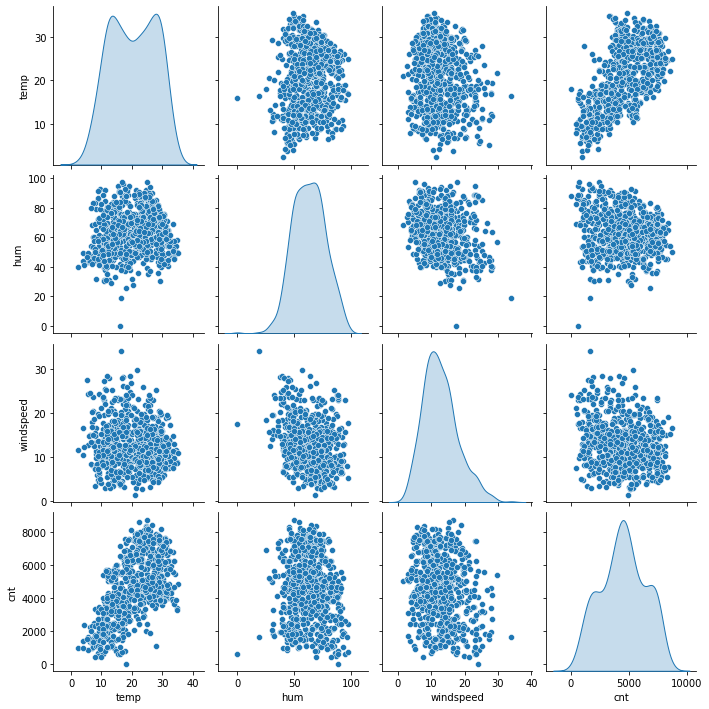

In [259]:
#check relationship between continuous variables 
df_bike_select=df_bike[['temp', 'hum', 'windspeed','cnt']]

sns.pairplot(df_bike_select, diag_kind='kde')
plt.show()

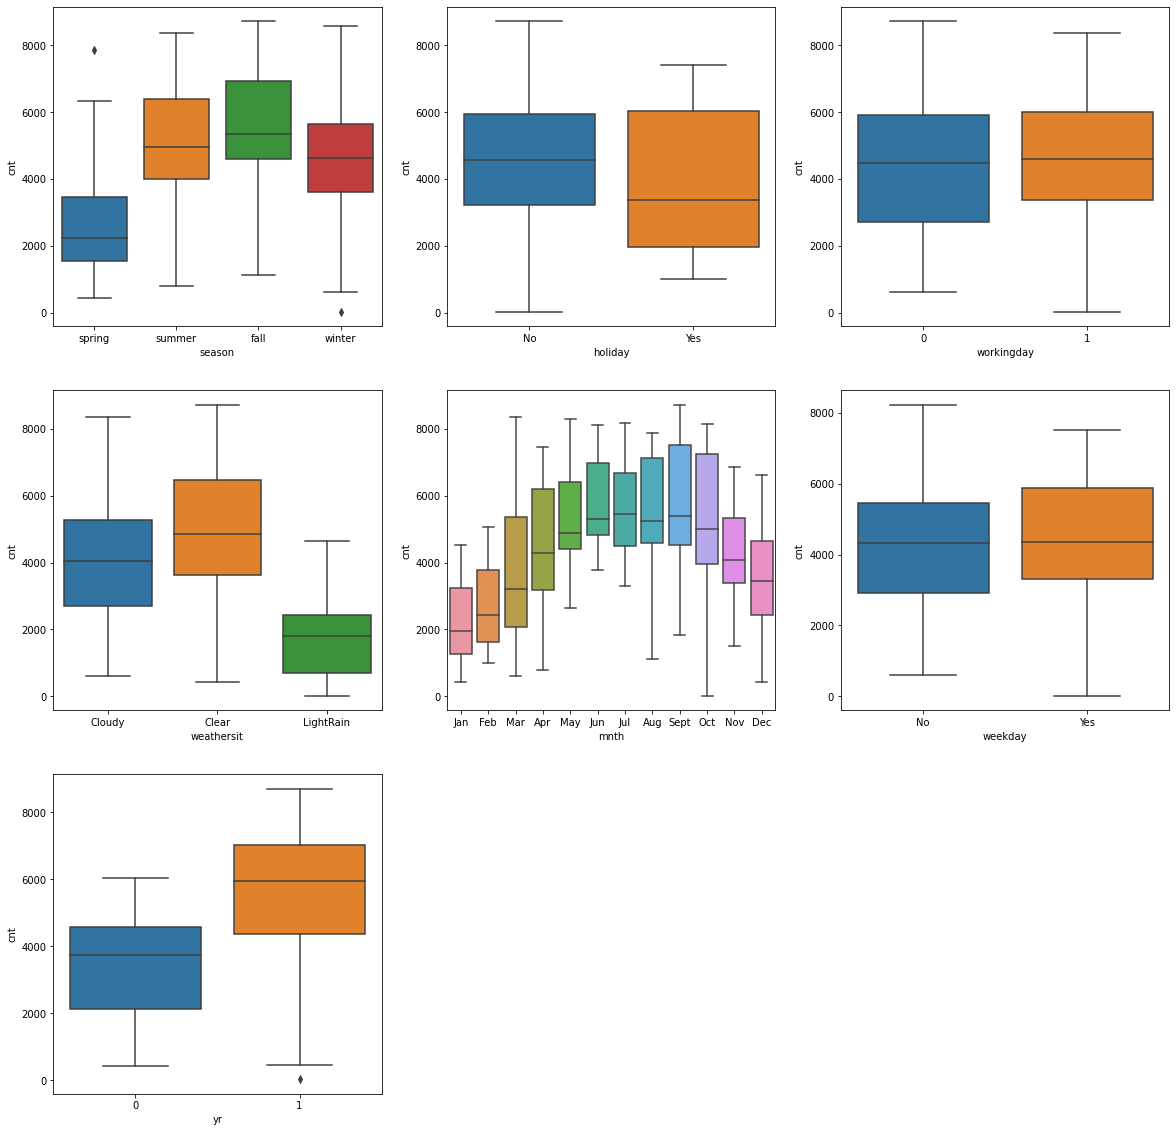

In [260]:
plt.figure(figsize=(20, 20))  
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', data = df_bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike)
plt.subplot(3,3,7)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bike)
plt.show()

# Inference:
# Yr - > there has been increase over the year
# Season -> summer and fall has increase 
# Weathersit -> Clear, Few clouds, Partly cloudy, Partly cloudy has highest sharing
# Holiday -> Lower sharing on holidays
# Season : there is relationship between Season and months. 
# Spring : Dec, Jan, Feb, Mar
# Summer : Mar, Apr, May, Jun
# Fall   : Jun, Jul Aug, Sep
# Winter : Sep, Oct, Nov, Dec

In [261]:
#Convert categorial variables into category data type to create dummy columns
df_bike['season']     = df_bike['season'].astype('category')
df_bike['holiday'] = df_bike['holiday'].astype('category')
df_bike['mnth'] = df_bike['mnth'].astype('category')
df_bike['weathersit'] = df_bike['weathersit'].astype('category')
df_bike['weekday']    = df_bike['weekday'].astype('category')
df_bike['workingday']    = df_bike['workingday'].astype('category')

In [262]:
df_new_bike = pd.get_dummies(df_bike, drop_first=True)
df_new_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   yr                    730 non-null    int64  
 1   temp                  730 non-null    float64
 2   hum                   730 non-null    float64
 3   windspeed             730 non-null    float64
 4   cnt                   730 non-null    int64  
 5   season_spring         730 non-null    uint8  
 6   season_summer         730 non-null    uint8  
 7   season_winter         730 non-null    uint8  
 8   mnth_Aug              730 non-null    uint8  
 9   mnth_Dec              730 non-null    uint8  
 10  mnth_Feb              730 non-null    uint8  
 11  mnth_Jan              730 non-null    uint8  
 12  mnth_Jul              730 non-null    uint8  
 13  mnth_Jun              730 non-null    uint8  
 14  mnth_Mar              730 non-null    uint8  
 15  mnth_May              7

# Split the data into training and testing Sets

In [263]:
# We should specify 'random_state' so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(df_new_bike, train_size = 0.70, test_size = 0.30, random_state = 100)

#Rescaling features

In [264]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ls_num_vars = ['temp', 'hum', 'windspeed','cnt']
df_train[ls_num_vars] = scaler.fit_transform(df_train[ls_num_vars])

# Dividing into X and Y sets for the model building

In [265]:
y_train = df_train.pop('cnt')
X_train = df_train

# Building our model

## RFE

In [266]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select = 10)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 3),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 9),
 ('mnth_Dec', False, 6),
 ('mnth_Feb', False, 7),
 ('mnth_Jan', False, 4),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 14),
 ('mnth_Mar', False, 13),
 ('mnth_May', False, 8),
 ('mnth_Nov', False, 5),
 ('mnth_Oct', False, 12),
 ('mnth_Sept', True, 1),
 ('holiday_Yes', True, 1),
 ('weekday_Yes', False, 11),
 ('workingday_1', False, 10),
 ('weathersit_Cloudy', False, 2),
 ('weathersit_LightRain', True, 1)]

In [267]:
ls_selected_col = X_train.columns[rfe.support_]
ls_selected_col

Index(['yr', 'temp', 'hum', 'windspeed', 'season_spring', 'season_winter',
       'mnth_Jul', 'mnth_Sept', 'holiday_Yes', 'weathersit_LightRain'],
      dtype='object')

### Building model using statsmodel

In [268]:
# Adding a constant variable 
import statsmodels.api as sm  
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[ls_selected_col]
 
X_train_rfe = sm.add_constant(X_train_rfe)

In [269]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     242.9
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.53e-184
Time:                        16:28:21   Log-Likelihood:                 489.69
No. Observations:                 510   AIC:                            -957.4
Df Residuals:                     499   BIC:                            -910.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3769 

In [270]:
df_vif = X_train_rfe.drop(['const'], axis=1)
GetVIF(df_vif)

,Features,VIF
2,hum,15.1800
1,temp,13.0900
3,windspeed,4.0200
4,season_spring,2.4000
0,yr,2.0600
5,season_winter,1.9800
6,mnth_Jul,1.4000
7,mnth_Sept,1.2000
9,weathersit_LightRain,1.1100
8,holiday_Yes,1.0400


In [271]:
X_train_rfe = X_train_rfe.drop(["hum"], axis = 1)
lm1 = GetLinearRegression(X_train_rfe, y_train)
lm1.params

const                   0.2042
yr                      0.2350
temp                    0.4758
windspeed              -0.1325
season_spring          -0.1032
season_winter           0.0504
mnth_Jul               -0.0616
mnth_Sept               0.0498
holiday_Yes            -0.0862
weathersit_LightRain   -0.2562
dtype: float64

In [272]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     228.8
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          5.33e-171
Time:                        16:28:21   Log-Likelihood:                 454.89
No. Observations:                 510   AIC:                            -889.8
Df Residuals:                     500   BIC:                            -847.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2042      0.025      8.095      0.000       0.155       0.254
yr                       0.2350      0.009     26.233      0.000       0.217       0.253
temp                     0.4758      0.033     14.453      0.000       0.411       0.540
windspeed               -0.1325      0.027     -4.879      0.000      -0.186      -0.079
season_spring           -0.1032      0.016     -6.274      0.000      -0.136      -0.071
season_winter            0.0504      0.013      3.754      0.000       0.024       0.077
mnth_Jul                -0.0616      0.019     -3.272      0.001      -0.099      -0.025
mnth_Sept                0.0498      0.017      2.911      0.004       0.016       0.083
holiday_Yes             -0.0862      0.028     -3.041      0.002      -0.142      -0.030
weathersit_LightRain    -0.2562      0.027     -9.608      0.000      -0.309      -0.204
==============================================================================
Omnibus:                       62.894   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.633
Skew:                          -0.736   Prob(JB):                     4.71e-26
Kurtosis:                       4.823   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [273]:
df_vif = X_train_rfe.drop(['const'], axis=1)
GetVIF(df_vif)

,Features,VIF
1,temp,4.4000
2,windspeed,3.9800
0,yr,2.0600
3,season_spring,1.6100
4,season_winter,1.3700
5,mnth_Jul,1.3400
6,mnth_Sept,1.2000
8,weathersit_LightRain,1.0600
7,holiday_Yes,1.0400


In [274]:
X_train_rfe = X_train_rfe.drop(["mnth_Sept"], axis = 1)
lm2 = GetLinearRegression(X_train_rfe, y_train)
lm2.params

const                   0.2038
yr                      0.2345
temp                    0.4908
windspeed              -0.1399
season_spring          -0.1046
season_winter           0.0495
mnth_Jul               -0.0721
holiday_Yes            -0.0812
weathersit_LightRain   -0.2521
dtype: float64

In [275]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     252.6
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          2.14e-170
Time:                        16:28:33   Log-Likelihood:                 450.60
No. Observations:                 510   AIC:                            -883.2
Df Residuals:                     501   BIC:                            -845.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2038      0.025      8.022      0.000       0.154       0.254
yr                       0.2345      0.009     25.988      0.000       0.217       0.252
temp                     0.4908      0.033     14.984      0.000       0.426       0.555
windspeed               -0.1399      0.027     -5.136      0.000      -0.193      -0.086
season_spring           -0.1046      0.017     -6.313      0.000      -0.137      -0.072
season_winter            0.0495      0.014      3.664      0.000       0.023       0.076
mnth_Jul                -0.0721      0.019     -3.869      0.000      -0.109      -0.035
holiday_Yes             -0.0812      0.028     -2.851      0.005      -0.137      -0.025
weathersit_LightRain    -0.2521      0.027     -9.397      0.000      -0.305      -0.199
==============================================================================
Omnibus:                       61.400   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.815
Skew:                          -0.702   Prob(JB):                     9.61e-27
Kurtosis:                       4.915   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [276]:
X_train_rfe = X_train_rfe.drop(["holiday_Yes"], axis = 1)
lm3 = GetLinearRegression(X_train_rfe, y_train)
lm3.params

const                   0.2033
yr                      0.2348
temp                    0.4900
windspeed              -0.1409
season_spring          -0.1069
season_winter           0.0471
mnth_Jul               -0.0709
weathersit_LightRain   -0.2494
dtype: float64

In [277]:
df_vif = X_train_rfe.drop(['const'], axis=1)
GetVIF(df_vif)

,Features,VIF
1,temp,3.9600
2,windspeed,3.9300
0,yr,2.0600
3,season_spring,1.6000
4,season_winter,1.3600
5,mnth_Jul,1.2900
6,weathersit_LightRain,1.0600


In [278]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     283.5
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          6.81e-170
Time:                        16:29:29   Log-Likelihood:                 446.50
No. Observations:                 510   AIC:                            -877.0
Df Residuals:                     502   BIC:                            -843.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2033      0.026      7.947      0.000       0.153       0.254
yr                       0.2348      0.009     25.845      0.000       0.217       0.253
temp                     0.4900      0.033     14.856      0.000       0.425       0.555
windspeed               -0.1409      0.027     -5.139      0.000      -0.195      -0.087
season_spring           -0.1069      0.017     -6.418      0.000      -0.140      -0.074
season_winter            0.0471      0.014      3.469      0.001       0.020       0.074
mnth_Jul                -0.0709      0.019     -3.780      0.000      -0.108      -0.034
weathersit_LightRain    -0.2494      0.027     -9.237      0.000      -0.302      -0.196
==============================================================================
Omnibus:                       64.231   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.636
Skew:                          -0.721   Prob(JB):                     1.17e-28
Kurtosis:                       4.993   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [280]:
X_train_rfe = X_train_rfe.drop(["season_winter"], axis = 1)
lm4 = GetLinearRegression(X_train_rfe, y_train)
lm4.params

const                   0.2596
yr                      0.2360
temp                    0.4279
windspeed              -0.1524
season_spring          -0.1413
mnth_Jul               -0.0715
weathersit_LightRain   -0.2413
dtype: float64

In [281]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     321.7
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.37e-168
Time:                        16:31:28   Log-Likelihood:                 440.46
No. Observations:                 510   AIC:                            -866.9
Df Residuals:                     503   BIC:                            -837.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2596      0.020     12.986      0.000       0.220       0.299
yr                       0.2360      0.009     25.713      0.000       0.218       0.254
temp                     0.4279      0.028     15.277      0.000       0.373       0.483
windspeed               -0.1524      0.028     -5.536      0.000      -0.206      -0.098
season_spring           -0.1413      0.014    -10.427      0.000      -0.168      -0.115
mnth_Jul                -0.0715      0.019     -3.769      0.000      -0.109      -0.034
weathersit_LightRain    -0.2413      0.027     -8.873      0.000      -0.295      -0.188
==============================================================================
Omnibus:                       54.941   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.150
Skew:                          -0.657   Prob(JB):                     1.09e-22
Kurtosis:                       4.742   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [282]:
df_vif = X_train_rfe.drop(['const'], axis=1)
GetVIF(df_vif)

,Features,VIF
1,temp,3.9500
2,windspeed,3.7200
0,yr,2.0300
3,season_spring,1.4900
4,mnth_Jul,1.2600
5,weathersit_LightRain,1.0400
